In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm
import pandas as pd
# from filterpy.kalman import KalmanFilter
from kalman import KalmanFilter
import os
import filter

import filter 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import data_clean as dc 
from kalman import KalmanFilter
from matplotlib.ticker import StrMethodFormatter
from geopy.distance import geodesic
import cleaner


# data exploration

In [ ]:
import cleaner

parent = '.data'
data_dict = cleaner.load_data(parent)

In [ ]:
dd = data_dict.copy()

In [ ]:
dd['train'].keys()
gps = dd['train']['t_gps']['PVS 1']

In [ ]:
# plot path
fig, ax =  plt.subplots(1,3,figsize=(12,5))

i = 0
for pvs in ['PVS 1', 'PVS 2', 'PVS 3']:
    gps = dd['train']['t_gps'][pvs]

    ax_cb = ax[i].scatter(gps['latitude'], gps['longitude'], s=1)
    # cbar = plt.colorbar(ax_cb, ax=ax[i])
    # cbar.set_label('Elevation (m)')
    ax[i].set_xlabel('Latitude')
    ax[i].set_ylabel('Longitude')
    ax[i].set_title(f'Course {i + 1}')

    ax[i].tick_params(axis='x', labelsize=8)  # Adjust x-axis ticks and labels size
    ax[i].tick_params(axis='y', labelsize=8) 
    ax[i].set_xticklabels(ax[i].get_xticks(), rotation=45)
    ax[i].xaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
    i += 1
plt.tight_layout()
plt.savefig('./figures/three_courses.png', dpi=300)
plt.show()

In [ ]:
gps.isna().sum()

In [ ]:
ddict = cleaner.clean_dict(cleaner.load_data(parent))

In [ ]:
verbose=False
inPlace=False

from geopy.distance import geodesic

def add_lat_long_meters(df):
    # convert the coordinates to meters 
    x_diffs = [geodesic((df['latitude'].iloc[0], df['longitude'].iloc[i]), (df['latitude'].iloc[i], df['longitude'].iloc[i])).meters for i in range(len(df)-1)]
    x_diffs.append(None)

    y_diffs = [geodesic((df['latitude'].iloc[i], df['longitude'].iloc[0]), (df['latitude'].iloc[i], df['longitude'].iloc[i])).meters for i in range(len(df)-1)]
    y_diffs.append(None)

    df['lat_m'] = x_diffs
    df['long_m'] = y_diffs
    df.dropna(inplace=True)
    # return x_diffs, y_diffs

if not inPlace:
    ddict = ddict.copy()
names = ["latitude", "longitude"]
for t_type in ddict:
    for csvf in ddict[t_type]:
        try:
            for dir in ddict[t_type][csvf]:
                if 'latitude' in ddict[t_type][csvf][dir].columns:
                    d = ddict[t_type][csvf][dir]
                    add_lat_long_meters(d)
                    
                    if verbose:
                        print("Added Lat/Long meters to", csvf + " " + dir)
                    
        except TypeError:
            continue
ddict

In [ ]:
ddict['train']['t_gps']['PVS 1']

# kalman - original 
doesn't work

In [ ]:
import cleaner

parent = '.data'
data_dict = cleaner.clean_dict(cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"]))

In [ ]:
def build_z_dash(df, type="train", road="good_road_left"):
    """
    Builds a 1 column dataset from the given dictionary of dataframes
    timestamp
    latitude
    longitude
    elevation
    acc_x_dash_smooth
    acc_y_dash_smooth
    acc_z_dash_smooth

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    """
    result = None
    lengths = []
    for folder in df[type]["gps_mpu_left"].keys():
        pvsi = df[type]["gps_mpu_left"][folder]
        labels = df[type]["labels"][folder][road]
        indices = labels[labels == 1].index

        new_data = pvsi.loc[indices]
        lengths.append(len(new_data))

        if result is None:
            result = new_data
        else:
            # append on the same column
            result = pd.concat([result, new_data], axis=0)

    return result, lengths
    


def build_gps_data(df, type="train"):
    """
    Builds a 6 column dataset from the given dataframe

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    :return: list of lengths
    """
    result = {}
    for folder in df[type]["gps_mpu_left"].keys():
        # pvsi = df[type]["gps_mpu_left"][folder][["timestamp", "meters_latitude", "meters_longitude", "acc_x_dash_smooth", "acc_y_dash_smooth", "acc_z_dash_smooth"]]
        pvsi = df[type]["gps_mpu_left"][folder][["timestamp", "meters_latitude", "meters_longitude", "acc_x_dash", "acc_y_dash", "acc_z_dash"]]
        elevation = df[type]["t_gps"][folder][["timestamp", "meters_elevation"]]

        # merge the two dataframes on timestamp then remove timestamp
        pvsi = pd.merge(pvsi, elevation, on="timestamp")
        pvsi = pvsi.drop(columns=["timestamp"])

        result[folder] = pvsi
    return result


train_dict = {
    "good": build_z_dash(data_dict, type="train", road="good_road_left"),
    "regular": build_z_dash(data_dict, type="train", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="train", road="bad_road_left")
}

test_dict = {
    "good": build_z_dash(data_dict, type="test", road="good_road_left"),
    "regular": build_z_dash(data_dict, type="test", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="test", road="bad_road_left")
}

filter.add_smoothed_cols(data_dict, window=200)
filter.add_diff_cols(data_dict)

kal_data = build_gps_data(data_dict, type="train")
print(kal_data)
#print((data_dict["train"]["t_gps"]["PVS 1"]))

In [ ]:
kal_data_test = kal_data.copy()
kal_data_test['PVS 1']['acc_z_dash']  = kal_data_test['PVS 1']['acc_z_dash'] - kal_data_test['PVS 1']['acc_z_dash'].mean()

In [ ]:
kal_data['PVS 3']


Q = np.eye(9) * 0.1
R = np.eye(6) * 1000
dt = .1
F = np.array(  [[1,0,0,dt,0,0,0,0,0],
                [0,1,0,0,dt,0,0,0,0],
                [0,0,1,0,0,dt,0,0,0],
                [0,0,0,1,0,0,dt,0,0],
                [0,0,0,0,1,0,0,dt,0],
                [0,0,0,0,0,1,0,0,dt],
                [0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,0,1]])

G = np.ones((9,9))
# initial state
x0 = np.zeros(9)
P0 = 1e5 * Q
#P0 = 1e-1 * Q
# z = kal_data['PVS 1'][['meters_latitude', 'meters_longitude', 'meters_elevation', 'acc_x_dash_smooth','acc_y_dash_smooth', 'acc_z_dash_smooth']].to_numpy().T
z = kal_data_test['PVS 1'][['meters_latitude', 'meters_longitude', 'meters_elevation', 'acc_x_dash','acc_y_dash', 'acc_z_dash']].to_numpy().T
# z = kal_data["PVS 1"].to_numpy().T
# print(kal_data["PVS 1"].columns)
tsteps = 1000


H = np.zeros((6, 9))
for i in range(3):
    H[i, i] = 1
    H[i + 3, i + 6] = 0

print(H)

# control u
u = np.zeros(9)
# u[-1] = -.98

kf = KalmanFilter(F, Q, H, R, G, u)
est = kf.estimate(x0, P0, z)

In [ ]:
# compare plots
fig, ax = plt.subplots(2,3,figsize=(12,8))

# plot latitude/longitude
ax[0,0].plot(est[0], est[1])
ax[0,0].plot(z[0], z[1])
ax[0,0].set_title('lat vs long (meters)')

# plot z position
x = range(est.shape[1])
ax[0,1].plot(x, est[2])
ax[0,1].plot(x, z[2])
ax[0,1].set_title('z meters')

# plot acceleration
ax[0,2].plot(x, est[6], label='predicted')
ax[0,2].plot(x, z[3], label='actual', zorder=0)
ax[0,2].set_title('x acceleration')
ax[0,2].legend()

# plot acceleration
ax[1,0].plot(x, est[7], label='predicted')
ax[1,0].plot(x, z[4], label='actual', zorder=0)
ax[1,0].set_title('y acceleration')
ax[1,0].legend()

# plot acceleration
ax[1,1].plot(x, est[8], label='predicted')
ax[1,1].plot(x, z[5], label='actual', zorder=0)
ax[1,1].set_title('z acceleration')
ax[1,1].legend()

plt.tight_layout()
plt.show()


# kalman without cleaned data
works! 

In [61]:
# load data
data = cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"])

In [62]:
data['train']['t_gps']['PVS 1']

,timestamp,latitude,longitude,elevation,accuracy,bearing,speed_meters_per_second,satellites,provider,hdop,vdop,pdop,geoidheight,ageofdgpsdata,dgpsid,activity,battery,annotation,distance_meters,elapsed_time_seconds
0,1.577219e+09,-27.717812,-51.098895,948.770836,24.0,159.73294,0.053275,0,gps,0.8,1.7,1.9,3.6,NaN,NaN,NaN,87,NaN,0.000000,0.0
1,1.577219e+09,-27.717818,-51.098840,970.378820,12.0,NaN,0.000000,12,gps,0.8,1.5,1.7,3.6,NaN,NaN,NaN,87,NaN,5.442520,2.0
2,1.577219e+09,-27.717832,-51.098871,989.374267,4.0,NaN,0.000000,13,gps,0.8,1.6,1.8,3.6,NaN,NaN,NaN,86,NaN,3.404871,5.0
3,1.577219e+09,-27.717833,-51.098867,988.439139,4.0,NaN,0.000000,14,gps,0.8,1.7,1.9,3.6,NaN,NaN,NaN,86,NaN,0.421733,1.0
4,1.577219e+09,-27.717835,-51.098873,987.668730,4.0,NaN,0.000000,14,gps,0.8,1.6,1.8,3.6,NaN,NaN,NaN,86,NaN,0.574281,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,1.577220e+09,-27.717778,-51.099069,980.865571,4.0,130.51640,0.017391,16,gps,0.8,1.3,1.5,3.6,NaN,NaN,NaN,81,NaN,0.176010,1.0
1463,1.577220e+09,-27.717773,-51.099072,981.469505,6.0,130.51602,0.033592,16,gps,0.8,1.3,1.5,3.6,NaN,NaN,NaN,81,NaN,0.644347,1.0
1464,1.577220e+09,-27.717773,-51.099078,979.980588,6.0,194.52164,0.761983,16,gps,0.9,1.3,1.5,3.6,NaN,NaN,NaN,81,NaN,0.614420,1.0
1465,1.577220e+09,-27.717777,-51.099073,979.903556,6.0,195.58694,0.054153,16,gps,0.8,1.3,1.5,3.6,NaN,NaN,NaN,81,NaN,0.645030,1.0


In [63]:
# select data
df = data['train']['gps_mpu_left']['PVS 1']

# average acceleration 
acc_x_cols = ['acc_x_dashboard', 'acc_x_above_suspension', 'acc_x_below_suspension']
acc_y_cols = ['acc_y_dashboard', 'acc_y_above_suspension', 'acc_y_below_suspension']
acc_z_cols = ['acc_z_dashboard', 'acc_z_above_suspension', 'acc_z_below_suspension']

df['acc_x'] = df[acc_x_cols].mean(axis=1)
df['acc_y'] = df[acc_y_cols].mean(axis=1)
df['acc_z'] = df[acc_z_cols].mean(axis=1)

# normalize z acc
df['acc_z'] = df['acc_z'] - df['acc_z'].mean()

# merge elevation data in 
cols = ['latitude', 'longitude', 'acc_x', 'acc_y', 'acc_z']
df = data['train']['gps_mpu_left']['PVS 1'][cols].merge(data['train']['t_gps']['PVS 1'][['latitude', 'longitude', 'elevation']], 'left', on=['latitude', 'longitude'])

In [64]:
# convert the coordinates to meters 
from geopy.distance import geodesic
reference_point = (df['latitude'].iloc[0], df['longitude'].iloc[0])
x_diffs = [geodesic((df['latitude'].iloc[0], df['longitude'].iloc[i]), (df['latitude'].iloc[i], df['longitude'].iloc[i])).meters for i in range(len(df)-1)]
x_diffs.append(None)

y_diffs = [geodesic((df['latitude'].iloc[i], df['longitude'].iloc[0]), (df['latitude'].iloc[i], df['longitude'].iloc[i])).meters for i in range(len(df)-1)]
y_diffs.append(None)

In [65]:
# add to dataframe
df['lat_m'] = x_diffs
df['long_m'] = y_diffs
df.dropna(inplace=True)

In [419]:
df

,latitude,longitude,acc_x,acc_y,acc_z,elevation,lat_m,long_m
0,-27.717841,-51.098865,0.239180,0.171079,0.020464,985.245045,0.000000,0.000000
1,-27.717841,-51.098865,0.266314,0.186641,0.001709,985.245045,0.000000,0.000000
2,-27.717841,-51.098865,0.231997,0.197016,0.040016,985.245045,0.000000,0.000000
3,-27.717841,-51.098865,0.230401,0.189035,0.017670,985.245045,0.000000,0.000000
4,-27.717841,-51.098865,0.246761,0.187439,0.061564,985.245045,0.000000,0.000000
...,...,...,...,...,...,...,...,...
144030,-27.717777,-51.099070,-0.680992,-0.229152,-0.137155,979.779629,7.140333,20.163527
144031,-27.717777,-51.099070,-0.521378,-0.187652,-0.147929,979.779629,7.140333,20.163527
144032,-27.717777,-51.099070,-0.623531,-0.400736,-0.041387,979.779629,7.140333,20.163527
144033,-27.717777,-51.099070,-0.400072,-0.147749,0.090294,979.779629,7.140333,20.163527


In [70]:
Q = np.eye(9) * 0.1
R = np.eye(6) * 1000
dt = .1
F = np.array(  [[1,0,0,dt,0,0,0,0,0],
                [0,1,0,0,dt,0,0,0,0],
                [0,0,1,0,0,dt,0,0,0],
                [0,0,0,1,0,0,dt,0,0],
                [0,0,0,0,1,0,0,dt,0],
                [0,0,0,0,0,1,0,0,dt],
                [0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,0,1]])

G = np.ones((9,9))
# initial state
x0 = np.zeros(9)
P0 = 1e5 * Q
# z = df[['lat_m', 'long_m', 'elevation', 'acc_x', 'acc_y', 'acc_z']].to_numpy().T
tsteps = 1000


H = np.zeros((6, 9))
for i in range(3):
    H[i, i] = 1
    H[i + 3, i + 6] = 1

print(H)

# control u
u = np.zeros(9)
# u[-1] = -.98

kf = KalmanFilter(F, Q, H, R, G, u)
z_original = df[['lat_m', 'long_m', 'elevation', 'acc_x', 'acc_y', 'acc_z']].to_numpy().T
est_original = kf.estimate(x0,P0,z_original)
z_cleaned = df[['lat_m', 'long_m', 'elevation', 'acc_x', 'acc_y', 'acc_z']].to_numpy().T[:,::10]
est_cleaned = kf.estimate(x0, P0, z_cleaned)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_30843/2502252796.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0,0] = plt.subplot2grid(shape=(2,6), loc=(0,1), colspan=2)
/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_30843/2502252796.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0,1] = plt.subplot2grid((2,6), (0,3), colspan=2)
/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_30843/2502252796.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0,2] = plt.subplot2grid((2,6), (1,0), colspan=2)
/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_30843/2

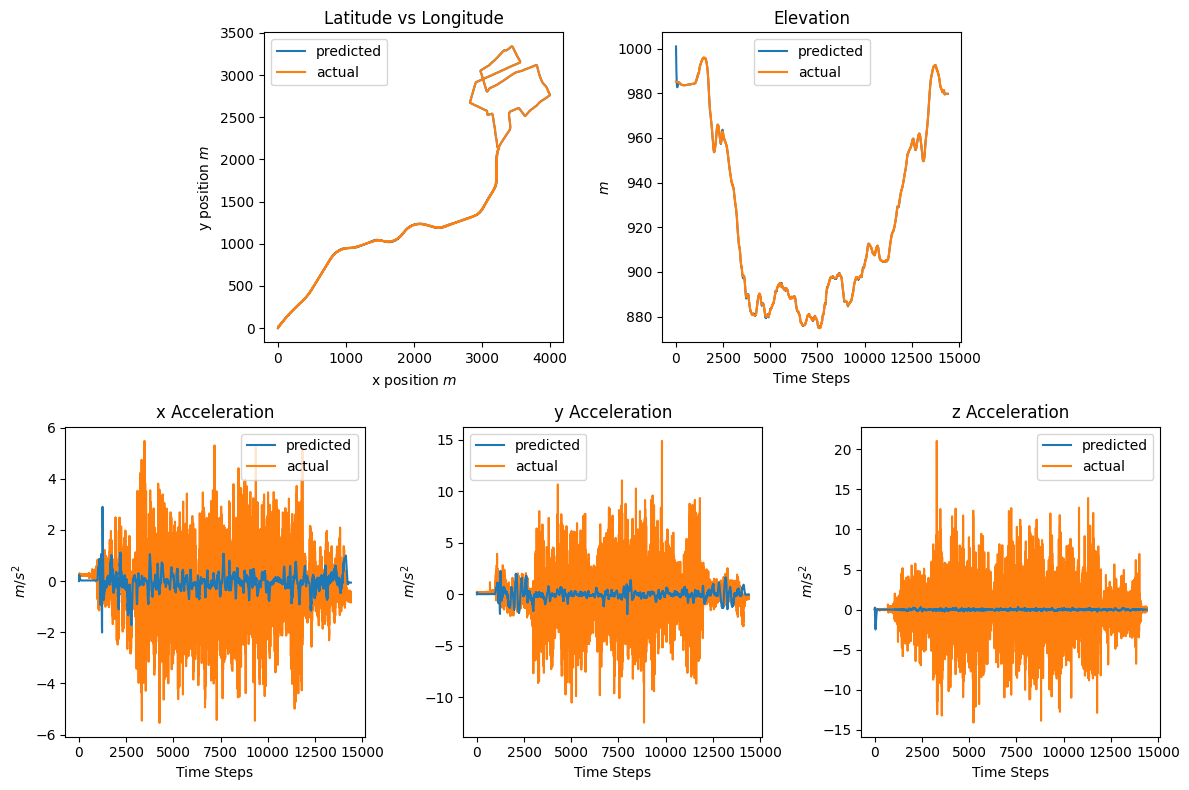

In [71]:
est = est_cleaned
z = z_cleaned
# compare plots
fig, ax = plt.subplots(2,3,figsize=(12,8))

ax[0,0] = plt.subplot2grid(shape=(2,6), loc=(0,1), colspan=2)
ax[0,1] = plt.subplot2grid((2,6), (0,3), colspan=2)
ax[0,2] = plt.subplot2grid((2,6), (1,0), colspan=2)
ax[1,0] = plt.subplot2grid((2,6), (1,2), colspan=2)
ax[1,1] = plt.subplot2grid((2,6), (1,4), colspan=2)

x = range(est.shape[1])

# plot latitude/longitude
ax[0,0].plot(est[0, 20:], est[1, 20:], label='predicted')
ax[0,0].plot(z[0], z[1], label='actual')
ax[0,0].set_title('Latitude vs Longitude')
ax[0,0].legend()
ax[0,0].set_xlabel('x position $m$')
ax[0,0].set_ylabel('y position $m$')
# ax[0,0].set_ylim(-55,-50)

# plot z position
ax[0,1].plot(x[10:], est[2,10:], label='predicted')
ax[0,1].plot(x[1:], z[2,1:], label='actual')
ax[0,1].set_title('Elevation')
ax[0,1].set_ylabel('$m$')
ax[0,1].set_xlabel('Time Steps')
ax[0,1].legend()

# plot acceleration
ax[0,2].plot(x, est[6], label='predicted')
ax[0,2].plot(x, z[3], label='actual', zorder=0)
ax[0,2].set_title('x Acceleration')
ax[0,2].set_ylabel('$m/s^2$')
ax[0,2].set_xlabel('Time Steps')
ax[0,2].legend()

# plot acceleration
ax[1,0].plot(x, est[7], label='predicted')
ax[1,0].plot(x, z[4], label='actual', zorder=0)
ax[1,0].set_title('y Acceleration' )
ax[1,0].set_ylabel('$m/s^2$')
ax[1,0].set_xlabel('Time Steps')
ax[1,0].legend()
# ax[1,0].set_xlim(50000, 50100)

# plot acceleration
ax[1,1].plot(x, est[8], label='predicted')
ax[1,1].plot(x, z[5], label='actual', zorder=0)
ax[1,1].set_title('z Acceleration')
ax[1,1].set_ylabel('$m/s^2$')
ax[1,1].set_xlabel('Time Steps')
ax[1,1].legend()
# ax[1,1].set_xlim(50000, 50100)

plt.tight_layout()
# plt.show()
plt.savefig('figures/kalman.png', dpi=300)


/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_10569/2146766688.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0,0] = plt.subplot2grid(shape=(2,6), loc=(0,1), colspan=2)
/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_10569/2146766688.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0,2] = plt.subplot2grid((2,6), (0,3), colspan=2)
/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_10569/2146766688.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[1,0] = plt.subplot2grid((2,6), (1,0), colspan=2)
/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_10569/2

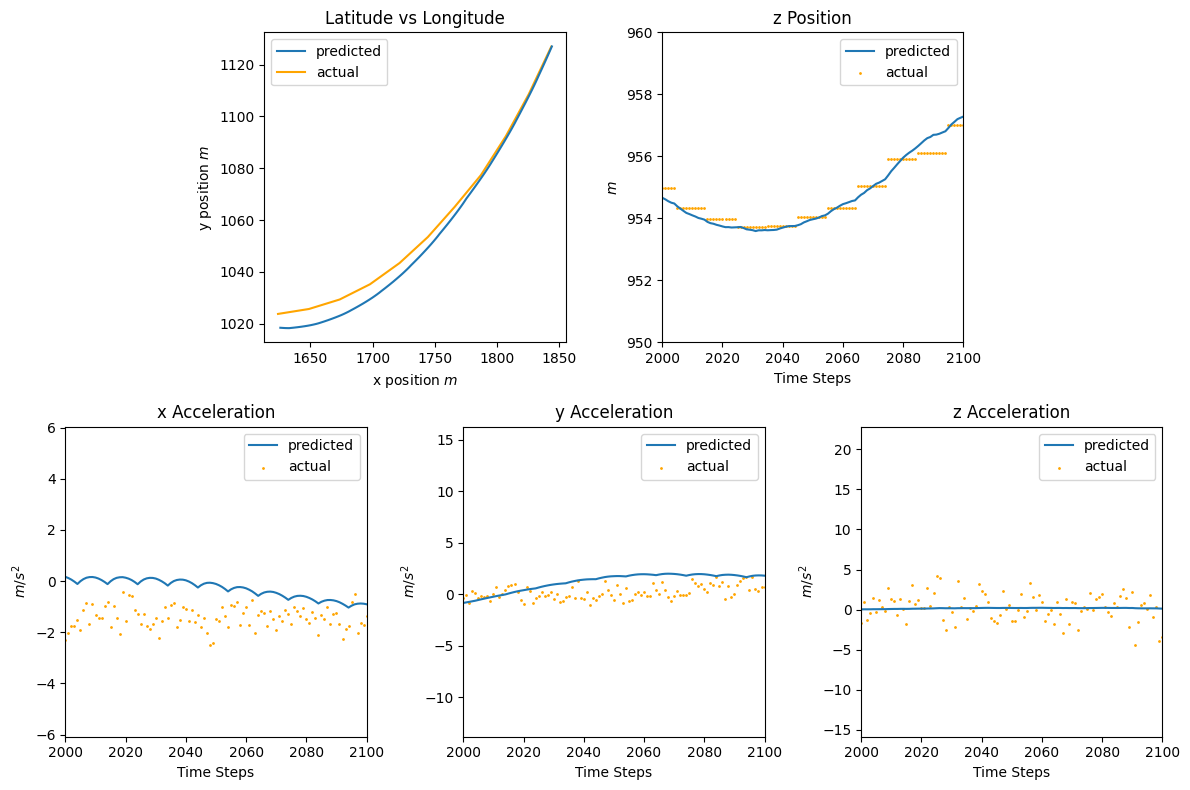

In [549]:
est = est_cleaned
z = z_cleaned

# compare plots
fig, ax = plt.subplots(2,3,figsize=(12,8))

ax[0,0] = plt.subplot2grid(shape=(2,6), loc=(0,1), colspan=2)
ax[0,2] = plt.subplot2grid((2,6), (0,3), colspan=2)
ax[1,0] = plt.subplot2grid((2,6), (1,0), colspan=2)
ax[1,1] = plt.subplot2grid((2,6), (1,2), colspan=2)
ax[1,2] = plt.subplot2grid((2,6), (1,4), colspan=2)

xlim = (2000, 2100)

x = range(est.shape[1])

# plot latitude/longitude
ax[0,0].plot(est[0][xlim[0]:xlim[1]], est[1][xlim[0]:xlim[1]], label='predicted')
# ax[0,0].plot(z[0], z[1], label='actual', zorder=0,color='orange')
ax[0,0].plot(z[0][xlim[0]:xlim[1]], z[1][xlim[0]:xlim[1]], label='actual', zorder=0,color='orange',)
ax[0,0].set_title('Latitude vs Longitude')
ax[0,0].legend()
ax[0,0].set_xlabel('x position $m$')
ax[0,0].set_ylabel('y position $m$')
# ax[0,0].set_xlim(xlim[0], xlim[1])
# ax[0,0].set_ylim(1200,1250)

# # plot x position
# ax[0,0].plot(x, est[0], label='predicted',)
# ax[0,0].scatter(x, z[0], label='actual', s=1, color='orange', zorder=0)
# ax[0,0].set_title('x Position')
# ax[0,0].set_ylabel('$m$')
# ax[0,0].set_xlabel('Time Steps')
# ax[0,0].legend()
# ax[0,0].set_xlim(xlim[0], xlim[1])
# ax[0,0].set_ylim(1600,1900)


# # plot y position
# ax[0,1].plot(x, est[1], label='predicted',)
# ax[0,1].scatter(x, z[1], label='actual', s=1, color='orange', zorder=0)
# ax[0,1].set_title('y Position')
# ax[0,1].set_ylabel('$m$')
# ax[0,1].set_xlabel('Time Steps')
# ax[0,1].legend()
# ax[0,1].set_xlim(xlim[0], xlim[1])
# ax[0,1].set_ylim(1000,1200)


# plot z position
ax[0,2].plot(x, est[2], label='predicted',)
ax[0,2].scatter(x, z[2], label='actual', s=1, color='orange', zorder=0)
ax[0,2].set_title('z Position')
ax[0,2].set_ylabel('$m$')
ax[0,2].set_xlabel('Time Steps')
ax[0,2].legend()
ax[0,2].set_xlim(xlim[0], xlim[1])
ax[0,2].set_ylim(950,960)

# plot acceleration
ax[1,0].plot(x, est[6], label='predicted', )
ax[1,0].scatter(x, z[3], label='actual', zorder=0, c='orange', s=1)
ax[1,0].set_title('x Acceleration')
ax[1,0].set_ylabel('$m/s^2$')
ax[1,0].set_xlabel('Time Steps')
ax[1,0].set_xlim(xlim[0], xlim[1])
ax[1,0].legend()

# plot acceleration
ax[1,1].plot(x, est[7], label='predicted')
ax[1,1].scatter(x, z[4], label='actual', zorder=0, c='orange', s=1)
ax[1,1].set_title('y Acceleration' )
ax[1,1].set_ylabel('$m/s^2$')
ax[1,1].set_xlabel('Time Steps')
ax[1,1].set_xlim(xlim[0], xlim[1])
ax[1,1].legend()
# ax[1,0].set_xlim(50000, 50100)

# plot acceleration
ax[1,2].plot(x, est[8], label='predicted')
ax[1,2].scatter(x, z[5], label='actual', zorder=0, c='orange', s=1)
ax[1,2].set_title('z Acceleration')
ax[1,2].set_ylabel('$m/s^2$')
ax[1,2].set_xlabel('Time Steps')
ax[1,2].set_xlim(xlim[0], xlim[1])
ax[1,2].legend()
# ax[1,1].set_xlim(50000, 50100)

plt.tight_layout()
plt.savefig('figures/kalman_zoomed.png', dpi=300)
# plt.show()


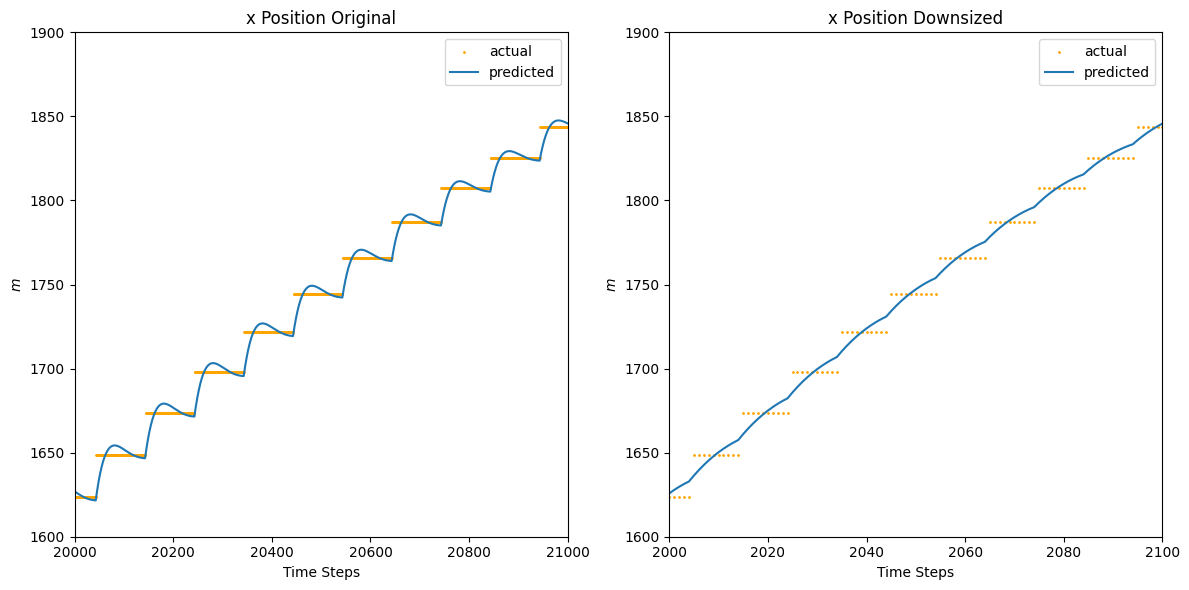

In [546]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].scatter(range(len(z_original[0])), z_original[0], label='actual', s=1, color='orange')
ax[0].plot(range(len(est_original[0])), est_original[0], label='predicted')
ax[0].set_title('x Position Original')
ax[0].set_ylabel('$m$')
ax[0].set_xlabel('Time Steps')
ax[0].legend()
ax[0].set_xlim(20000, 21000)
ax[0].set_ylim(1600,1900)


ax[1].scatter(range(len(z_cleaned[0])), z_cleaned[0], label='actual', s=1, color='orange')
ax[1].plot(range(len(est_cleaned[0])), est_cleaned[0], label='predicted')
ax[1].set_title('x Position Downsized')
ax[1].set_ylabel('$m$')
ax[1].set_xlabel('Time Steps')
ax[1].legend()
ax[1].set_xlim(2000, 2100)
ax[1].set_ylim(1600,1900)

plt.tight_layout()
plt.savefig('figures/kalman_downsize.png', dpi=300)

# spectral clustering 

In [4]:
from sklearn.cluster import KMeans, SpectralClustering
# load data
parent = '.data/'
data = cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"])

In [7]:
labels = data['train']['labels']['PVS 1']
sensor = data['train']['gps_mpu_left']['PVS 1']

In [8]:
X_master = sensor[['acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard',
       'acc_x_above_suspension', 'acc_y_above_suspension',
       'acc_z_above_suspension', 'acc_x_below_suspension',
       'acc_y_below_suspension', 'acc_z_below_suspension', 'gyro_x_dashboard',
       'gyro_y_dashboard', 'gyro_z_dashboard', 'gyro_x_above_suspension',
       'gyro_y_above_suspension', 'gyro_z_above_suspension',
       'gyro_x_below_suspension', 'gyro_y_below_suspension',
       'gyro_z_below_suspension']]

In [6]:
def fit_model(model, X, labels):
    # fit 
    model.fit(X)

    # predict
    model.predict(X)
    y_hat = model.labels_

    # extract y actual
    labels['cluster_labels'] = y_hat
    ll = pd.get_dummies(labels,columns=['cluster_labels'])

    # compare accuracies 
    for col in ['dirt_road', 'cobblestone_road','asphalt_road']:
        for c in ['cluster_labels_0', 'cluster_labels_1', 'cluster_labels_2']:
            acc = (ll[c] == ll[col]).sum()/len(ll[c])
            print(f'{col} + {c} acc: {acc}')

In [17]:
# test vanilla kmeans model 
X = X_master.copy()
kmeans = KMeans(3)
fit_model(kmeans, X, labels.copy())

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


dirt_road + cluster_labels_0 acc: 0.7052195284512205
dirt_road + cluster_labels_1 acc: 0.39951817601155265
dirt_road + cluster_labels_2 acc: 0.7156683051459357
cobblestone_road + cluster_labels_0 acc: 0.5767585881307451
cobblestone_road + cluster_labels_1 acc: 0.4179510677886084
cobblestone_road + cluster_labels_2 acc: 0.5772098642006165
asphalt_road + cluster_labels_0 acc: 0.5214113138382072
asphalt_road + cluster_labels_1 acc: 0.5560276597517287
asphalt_road + cluster_labels_2 acc: 0.5302354966813853


In [19]:
# only taking 10 percent of data
X = X_master[::10]
y = labels[::10]
kmeans = KMeans(3)
fit_model(kmeans, X, y)

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


dirt_road + cluster_labels_0 acc: 0.4021105248542072
dirt_road + cluster_labels_1 acc: 0.7005692863093586
dirt_road + cluster_labels_2 acc: 0.7177173007497917
cobblestone_road + cluster_labels_0 acc: 0.4227992224382116
cobblestone_road + cluster_labels_1 acc: 0.5750485976117745
cobblestone_road + cluster_labels_2 acc: 0.5741460705359622
asphalt_road + cluster_labels_0 acc: 0.5558872535406831
asphalt_road + cluster_labels_1 acc: 0.5199944459872258
asphalt_road + cluster_labels_2 acc: 0.5317272979727853


/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_25871/3235640350.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['cluster_labels'] = y_hat


In [37]:
def eval_model(labels, y_hat):
    # extract y actual
    labels['cluster_labels'] = y_hat
    ll = pd.get_dummies(labels,columns=['cluster_labels'])

    # compare accuracies 
    for col in ['dirt_road', 'cobblestone_road','asphalt_road']:
        for c in ['cluster_labels_0', 'cluster_labels_1', 'cluster_labels_2']:
            acc = (ll[c] == ll[col]).sum()/len(ll[c])
            print(f'{col} + {c} acc: {acc}')

In [21]:
# testing spectral clustering
X = X_master[::10]
y = labels[::10]
spectral_clustering = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
y_hat = spectral_clustering.fit_predict(X)


In [23]:
eval_model(y, y_hat)

dirt_road + cluster_labels_0 acc: 0.7546514856984171
dirt_road + cluster_labels_1 acc: 0.43265759511246876
dirt_road + cluster_labels_2 acc: 0.6330880311024716
cobblestone_road + cluster_labels_0 acc: 0.506248264371008
cobblestone_road + cluster_labels_1 acc: 0.5012496528742016
cobblestone_road + cluster_labels_2 acc: 0.5644959733407386
asphalt_road + cluster_labels_0 acc: 0.6726603721188559
asphalt_road + cluster_labels_1 acc: 0.44494584837545126
asphalt_road + cluster_labels_2 acc: 0.4900027770063871


/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_25871/127684231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['cluster_labels'] = y_hat


In [31]:
pd.options.mode.chained_assignment = None

Trying out clustering on cleaned data

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:

X = X_master[::10]
print(X.columns)

# average acceleration 
acc_x_cols = ['acc_x_dashboard', 'acc_x_above_suspension', 'acc_x_below_suspension']
acc_y_cols = ['acc_y_dashboard', 'acc_y_above_suspension', 'acc_y_below_suspension']
acc_z_cols = ['acc_z_dashboard', 'acc_z_above_suspension', 'acc_z_below_suspension']

gyro_x_cols = ['gyro_x_dashboard', 'gyro_x_above_suspension', 'gyro_x_below_suspension']
gyro_y_cols = ['gyro_y_dashboard', 'gyro_y_above_suspension', 'gyro_y_below_suspension']
gyro_z_cols = ['gyro_z_dashboard', 'gyro_z_above_suspension', 'gyro_z_below_suspension']

X['acc_x'] = X[acc_x_cols].mean(axis=1)
X['acc_y'] = X[acc_y_cols].mean(axis=1)
X['acc_z'] = X[acc_z_cols].mean(axis=1)

X['gyro_x'] = X[gyro_x_cols].mean(axis=1)
X['gyro_y'] = X[gyro_y_cols].mean(axis=1)
X['gyro_z'] = X[gyro_z_cols].mean(axis=1)

X = X[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]


# check to see what happens if we take data from the prev 10 windows and post 10 windows 
window_size = 10
means = np.zeros((len(X), 6))
stds = np.zeros((len(X), 6))
mins = np.zeros((len(X), 6))
maxs = np.zeros((len(X), 6))
for i in range(len(X)):
    # extract window

    if i < 10:
        window = X.iloc[0:i+window_size+1]
    elif i > len(X) - 10:
         window = X.iloc[i-window_size:]
    else: 
         window = X.iloc[i-window_size:i+window_size+1]

    window_mean = np.mean(window, axis=0)
    means[i, :] = window_mean.values

    window_std = np.std(window, axis=0)
    stds[i, :] = window_std.values

    window_min = np.min(window, axis=0)
    mins[i, :] = window_min.values

    window_max = np.max(window, axis=0)
    maxs[i, :] = window_max.values


X['acc_x_mean'] = means[:, 0]
X['acc_y_mean'] = means[:, 1]
X['acc_z_mean'] = means[:, 2]
X['gyro_x_mean'] = means[:, 3]
X['gyro_y_mean'] = means[:, 4]
X['gyro_z_mean'] = means[:, 5]

X['acc_x_std'] = stds[:, 0]
X['acc_y_std'] = stds[:, 1]
X['acc_z_std'] = stds[:, 2]
X['gyro_x_std'] = stds[:, 3]
X['gyro_y_std'] = stds[:, 4]
X['gyro_z_std'] = stds[:, 5]

X['acc_x_min'] = mins[:, 0]
X['acc_y_min'] = mins[:, 1]
X['acc_z_min'] = mins[:, 2]
X['gyro_x_min'] = mins[:, 3]
X['gyro_y_min'] = mins[:, 4]
X['gyro_z_min'] = mins[:, 5]

X['acc_x_max'] = maxs[:, 0]
X['acc_y_max'] = maxs[:, 1]
X['acc_z_max'] = maxs[:, 2]
X['gyro_x_max'] = maxs[:, 3]
X['gyro_y_max'] = maxs[:, 4]
X['gyro_z_max'] = maxs[:, 5]

Index(['acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard',
       'acc_x_above_suspension', 'acc_y_above_suspension',
       'acc_z_above_suspension', 'acc_x_below_suspension',
       'acc_y_below_suspension', 'acc_z_below_suspension', 'gyro_x_dashboard',
       'gyro_y_dashboard', 'gyro_z_dashboard', 'gyro_x_above_suspension',
       'gyro_y_above_suspension', 'gyro_z_above_suspension',
       'gyro_x_below_suspension', 'gyro_y_below_suspension',
       'gyro_z_below_suspension'],
      dtype='object')


/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_30843/90392187.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['acc_x'] = X[acc_x_cols].mean(axis=1)
/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_30843/90392187.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['acc_y'] = X[acc_y_cols].mean(axis=1)
/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_30843/90392187.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

testing 3 different clusters

In [41]:
# try spectral clustering to predict type of road
y = labels[::10]
spectral_clustering = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
y_hat = spectral_clustering.fit_predict(X)

# extract y actual
y['cluster_labels'] = y_hat
ll = pd.get_dummies(y,columns=['cluster_labels'])

# compare accuracies 
for col in ['dirt_road', 'cobblestone_road','asphalt_road']:
    for c in ['cluster_labels_0', 'cluster_labels_1', 'cluster_labels_2']:
        acc = (ll[c] == ll[col]).sum()/len(ll[c])
        print(f'{col} + {c} acc: {acc}')

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


dirt_road + cluster_labels_0 acc: 0.20098583726742572
dirt_road + cluster_labels_1 acc: 0.8005415162454874
dirt_road + cluster_labels_2 acc: 0.8188697584004443
cobblestone_road + cluster_labels_0 acc: 0.44675090252707583
cobblestone_road + cluster_labels_1 acc: 0.5547764509858373
cobblestone_road + cluster_labels_2 acc: 0.5704665370730353
asphalt_road + cluster_labels_0 acc: 0.37364620938628157
asphalt_road + cluster_labels_1 acc: 0.6248264371008053
asphalt_road + cluster_labels_2 acc: 0.6091363510136073


/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_30843/3299894766.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['cluster_labels'] = y_hat


In [ ]:
cobblestone_road + cluster_labels_0
asphalt_road + cluster_labels_1 
dirt_road + cluster_labels_2


In [47]:
ll['asphalt_road']

ll['combined_true'] = 0
ll['combined_true'] = ll['combined_true'] + ll['asphalt_road'] + 2*ll['dirt_road']


In [53]:
print((y_hat == ll['combined_true']).sum()/len(ll['combined_true']))
confusion_matrix(ll['combined_true'], y_hat)

0.4452235490141627


array([[6146,   19,    0],
       [5363,  267,   22],
       [2587,    0,    0]])

In [38]:
# try KMeans to predict type of road
y = labels[::10]
kmeans = KMeans(n_clusters=3)
y_hat = kmeans.fit(X).predict(X)
# extract y actual
y['cluster_labels'] = y_hat
ll = pd.get_dummies(y,columns=['cluster_labels'])

# compare accuracies 
for col in ['dirt_road', 'cobblestone_road','asphalt_road']:
    for c in ['cluster_labels_0', 'cluster_labels_1', 'cluster_labels_2']:
        acc = (ll[c] == ll[col]).sum()/len(ll[c])
        print(f'{col} + {c} acc: {acc}')

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


dirt_road + cluster_labels_0 acc: 0.5435295751180228
dirt_road + cluster_labels_1 acc: 0.6559289086364899
dirt_road + cluster_labels_2 acc: 0.6209386281588448
cobblestone_road + cluster_labels_0 acc: 0.36441266314912524
cobblestone_road + cluster_labels_1 acc: 0.6146903637878367
cobblestone_road + cluster_labels_2 acc: 0.5928908636489864
asphalt_road + cluster_labels_0 acc: 0.7424326575951125
asphalt_road + cluster_labels_1 acc: 0.431477367397945
asphalt_road + cluster_labels_2 acc: 0.4336989725076368


/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_30843/127684231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['cluster_labels'] = y_hat


asphalt_road + cluster_labels_0 /
dirt_road + cluster_labels_1 /
cobblestone_road + cluster_labels_2 


In [56]:
ll['asphalt_road']

ll['combined_true'] = 0
ll['combined_true'] = ll['combined_true'] + ll['dirt_road'] + 2*ll['cobblestone_road']

print((y_hat == ll['combined_true']).sum()/len(ll['combined_true']))
confusion_matrix(ll['combined_true'], y_hat)

0.2954040544293252


array([[1255, 3502,  895],
       [1083,  541,  963],
       [2666, 1040, 2459]])

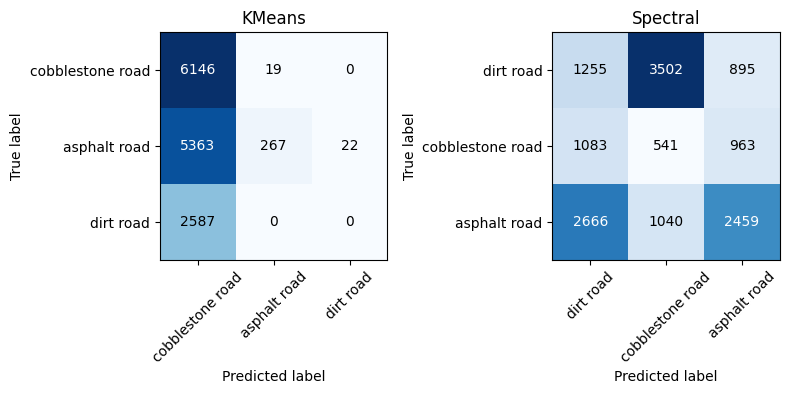

In [59]:
# Example usage
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

# plot kmeans
conf_matrix = np.array([[6146,   19,    0],
                        [5363,  267,   22],
                        [2587,    0,    0]])
classes = ['cobblestone road', 'asphalt road', 'dirt road']
plot_confusion_matrix(conf_matrix, classes, ax[0], 'KMeans')

# plot spectral 
conf_matrix = np.array([[1255, 3502,  895],
                        [1083,  541,  963],
                        [2666, 1040, 2459]])
classes = [ 'dirt road', 'cobblestone road', 'asphalt road']
plot_confusion_matrix(conf_matrix, classes, ax[1], 'Spectral')

# plt.suptitle('Predicting Road Type (2 Clusters)')
plt.tight_layout()
plt.savefig('figures/3_clusters.png', dpi=300)
plt.show()

testing cleaned data to predict paved vs unpaved roads

In [11]:
# spectral clustering 
y = labels[::10]
spectral_clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
y_hat = spectral_clustering.fit_predict(X)

# extract y actual
y['cluster_labels'] = y_hat
ll = pd.get_dummies(y,columns=['cluster_labels'])

# compare accuracies 
for col in ['paved_road', 'unpaved_road']:
    for c in ['cluster_labels_0', 'cluster_labels_1']:
        acc = (ll[c] == ll[col]).sum()/len(ll[c])
        print(f'{col} + {c} acc: {acc}')

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


paved_road + cluster_labels_0 acc: 0.8188697584004443
paved_road + cluster_labels_1 acc: 0.18113024159955568
unpaved_road + cluster_labels_0 acc: 0.18113024159955568
unpaved_road + cluster_labels_1 acc: 0.8188697584004443


/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_30843/1134015179.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['cluster_labels'] = y_hat


In [15]:
# get confusion matrix
print((y_hat == ll['unpaved_road']).sum()/len(ll[c]))
confusion_matrix(ll['unpaved_road'], y_hat)


0.8188697584004443


array([[11795,    22],
       [ 2587,     0]])

In [16]:
ll['unpaved_road'].sum()

2587

In [17]:
# kmeans
y = labels[::10]
kmeans = KMeans(n_clusters=2)
y_hat = kmeans.fit(X).predict(X)

# extract y actual
y['cluster_labels'] = y_hat
ll = pd.get_dummies(y,columns=['cluster_labels'])

# compare accuracies 
for col in ['paved_road', 'unpaved_road']:
    for c in ['cluster_labels_0', 'cluster_labels_1']:
        acc = (ll[c] == ll[col]).sum()/len(ll[c])
        print(f'{col} + {c} acc: {acc}')

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


paved_road + cluster_labels_0 acc: 0.5024298805887254
paved_road + cluster_labels_1 acc: 0.49757011941127466
unpaved_road + cluster_labels_0 acc: 0.49757011941127466
unpaved_road + cluster_labels_1 acc: 0.5024298805887254


/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_30843/2893109857.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['cluster_labels'] = y_hat


In [18]:
# get confusion matrix
print((y_hat == ll['unpaved_road']).sum()/len(ll[c]))
confusion_matrix(ll['unpaved_road'], y_hat)

0.5024298805887254


array([[5404, 6413],
       [ 754, 1833]])

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix, classes, ax, title):
    """
    Plot Confusion Matrix.

    Parameters:
    - conf_matrix: numpy.ndarray, confusion matrix
    - classes: list, class labels
    - ax: matplotlib.axes.Axes, axis to plot on
    """
    # Plotting the confusion matrix
    ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    # ax.colorbar()

    # Add class labels
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    # Add annotations
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

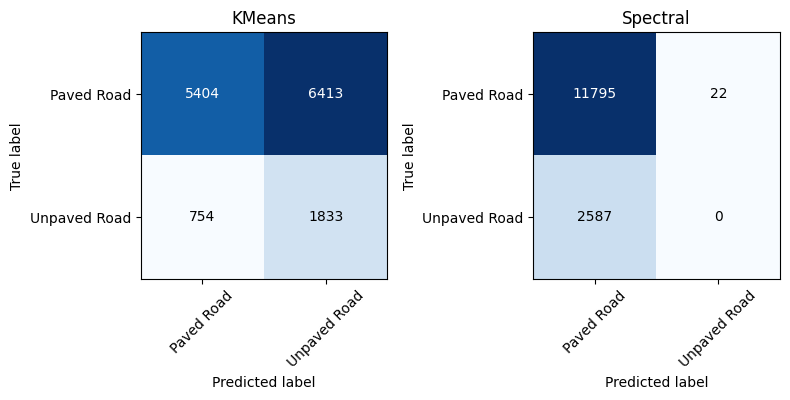

In [60]:
# Example usage
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

# plot kmeans
conf_matrix = np.array([[5404, 6413],
                    [ 754, 1833]])
classes = ['Paved Road', 'Unpaved Road']
plot_confusion_matrix(conf_matrix, classes, ax[0], 'KMeans')

# plot spectral 
conf_matrix = np.array([[11795, 22],
                        [2587, 0]])
classes = ['Paved Road', 'Unpaved Road']
plot_confusion_matrix(conf_matrix, classes, ax[1], 'Spectral')

# plt.suptitle('Predicting Road Type (2 Clusters)')
plt.tight_layout()
plt.savefig('figures/2_clusters.png', dpi=300)
plt.show()


In [ ]:
# Example usage
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

# plot kmeans
conf_matrix = np.array([[11795, 22],
                        [2587, 0]])
classes = ['Paved Road', 'Unpaved Road']
plot_confusion_matrix(conf_matrix, classes, ax[0], 'KMeans')

# plot spectral 
conf_matrix = np.array([[5404, 6413],
                    [ 754, 1833]])
classes = ['Paved Road', 'Unpaved Road']
plot_confusion_matrix(conf_matrix, classes, ax[1], 'Spectral')

# plt.suptitle('Predicting Road Type (2 Clusters)')
plt.tight_layout()
plt.savefig('figures/2_clusters.png', dpi=300)
plt.show()

# Testing clustering(agian)


In [1]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
# load data
parent = '.data/'
data = cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"])

In [7]:
labels = data['train']['labels']['PVS 1']
sensor = data['train']['gps_mpu_left']['PVS 1']
X_master = sensor[['acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard',
       'acc_x_above_suspension', 'acc_y_above_suspension',
       'acc_z_above_suspension', 'acc_x_below_suspension',
       'acc_y_below_suspension', 'acc_z_below_suspension', 'gyro_x_dashboard',
       'gyro_y_dashboard', 'gyro_z_dashboard', 'gyro_x_above_suspension',
       'gyro_y_above_suspension', 'gyro_z_above_suspension',
       'gyro_x_below_suspension', 'gyro_y_below_suspension',
       'gyro_z_below_suspension']]

In [8]:
X = X_master[::10]
print(X.columns)

# average acceleration 
acc_x_cols = ['acc_x_dashboard', 'acc_x_above_suspension', 'acc_x_below_suspension']
acc_y_cols = ['acc_y_dashboard', 'acc_y_above_suspension', 'acc_y_below_suspension']
acc_z_cols = ['acc_z_dashboard', 'acc_z_above_suspension', 'acc_z_below_suspension']

gyro_x_cols = ['gyro_x_dashboard', 'gyro_x_above_suspension', 'gyro_x_below_suspension']
gyro_y_cols = ['gyro_y_dashboard', 'gyro_y_above_suspension', 'gyro_y_below_suspension']
gyro_z_cols = ['gyro_z_dashboard', 'gyro_z_above_suspension', 'gyro_z_below_suspension']

X['acc_x'] = X[acc_x_cols].mean(axis=1)
X['acc_y'] = X[acc_y_cols].mean(axis=1)
X['acc_z'] = X[acc_z_cols].mean(axis=1)

X['gyro_x'] = X[gyro_x_cols].mean(axis=1)
X['gyro_y'] = X[gyro_y_cols].mean(axis=1)
X['gyro_z'] = X[gyro_z_cols].mean(axis=1)

X = X[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]


# check to see what happens if we take data from the prev 10 windows and post 10 windows 
window_size = 10
means = np.zeros((len(X), 6))
stds = np.zeros((len(X), 6))
mins = np.zeros((len(X), 6))
maxs = np.zeros((len(X), 6))
for i in range(len(X)):
    # extract window

    if i < 10:
        window = X.iloc[0:i+window_size+1]
    elif i > len(X) - 10:
         window = X.iloc[i-window_size:]
    else: 
         window = X.iloc[i-window_size:i+window_size+1]

    window_mean = np.mean(window, axis=0)
    means[i, :] = window_mean.values

    window_std = np.std(window, axis=0)
    stds[i, :] = window_std.values

    window_min = np.min(window, axis=0)
    mins[i, :] = window_min.values

    window_max = np.max(window, axis=0)
    maxs[i, :] = window_max.values


X['acc_x_mean'] = means[:, 0]
X['acc_y_mean'] = means[:, 1]
X['acc_z_mean'] = means[:, 2]
X['gyro_x_mean'] = means[:, 3]
X['gyro_y_mean'] = means[:, 4]
X['gyro_z_mean'] = means[:, 5]

X['acc_x_std'] = stds[:, 0]
X['acc_y_std'] = stds[:, 1]
X['acc_z_std'] = stds[:, 2]
X['gyro_x_std'] = stds[:, 3]
X['gyro_y_std'] = stds[:, 4]
X['gyro_z_std'] = stds[:, 5]

X['acc_x_min'] = mins[:, 0]
X['acc_y_min'] = mins[:, 1]
X['acc_z_min'] = mins[:, 2]
X['gyro_x_min'] = mins[:, 3]
X['gyro_y_min'] = mins[:, 4]
X['gyro_z_min'] = mins[:, 5]

X['acc_x_max'] = maxs[:, 0]
X['acc_y_max'] = maxs[:, 1]
X['acc_z_max'] = maxs[:, 2]
X['gyro_x_max'] = maxs[:, 3]
X['gyro_y_max'] = maxs[:, 4]
X['gyro_z_max'] = maxs[:, 5]

Index(['acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard',
       'acc_x_above_suspension', 'acc_y_above_suspension',
       'acc_z_above_suspension', 'acc_x_below_suspension',
       'acc_y_below_suspension', 'acc_z_below_suspension', 'gyro_x_dashboard',
       'gyro_y_dashboard', 'gyro_z_dashboard', 'gyro_x_above_suspension',
       'gyro_y_above_suspension', 'gyro_z_above_suspension',
       'gyro_x_below_suspension', 'gyro_y_below_suspension',
       'gyro_z_below_suspension'],
      dtype='object')


/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_13332/90392187.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['acc_x'] = X[acc_x_cols].mean(axis=1)
/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_13332/90392187.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['acc_y'] = X[acc_y_cols].mean(axis=1)
/var/folders/bw/hb7ld_394fzb21vx3_dxpyyw0000gn/T/ipykernel_13332/90392187.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [11]:
l = labels[['paved_road', 'unpaved_road']]

In [13]:
l.value_counts()

paved_road  unpaved_road
1           0               118168
0           1                25868
Name: count, dtype: int64